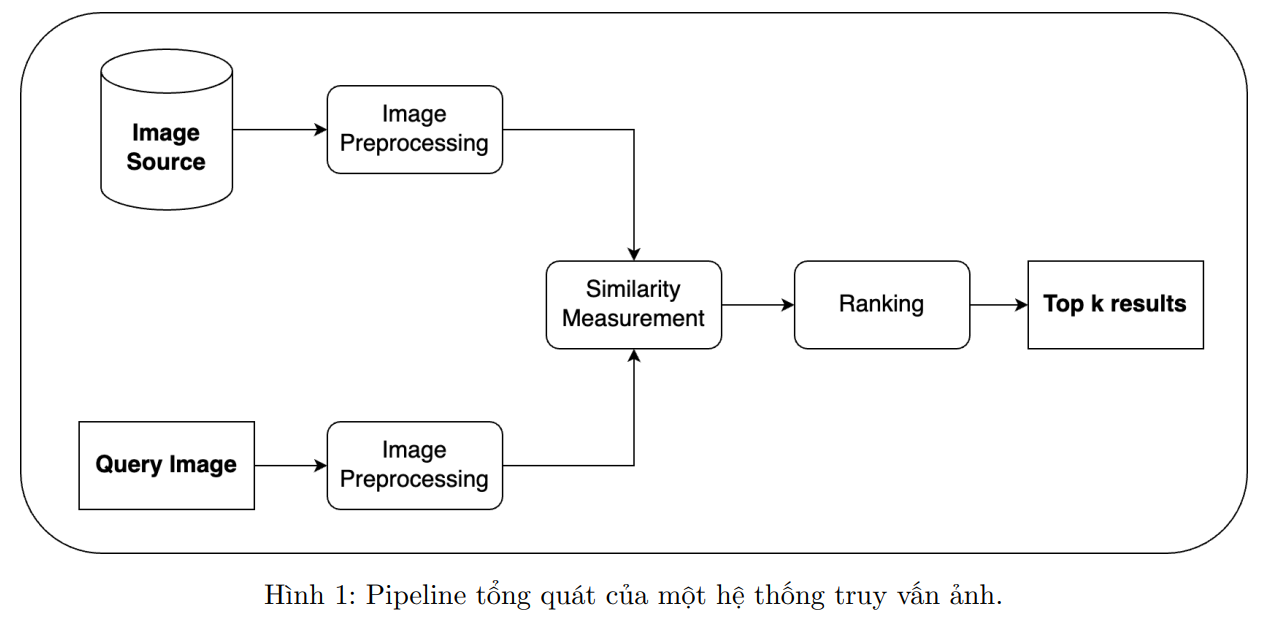

# Installation

In [4]:
!gdown 1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z
From (redirected): https://drive.google.com/uc?id=1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z&confirm=t&uuid=72d85639-dafd-4095-bcbd-39474bc92f90
To: d:\all-in-one\aio-2023\image_retrieval_dataset.zip

  0%|          | 0.00/36.5M [00:00<?, ?B/s]
  3%|▎         | 1.05M/36.5M [00:00<00:04, 7.85MB/s]
  7%|▋         | 2.62M/36.5M [00:00<00:03, 10.1MB/s]
 11%|█▏        | 4.19M/36.5M [00:00<00:02, 10.9MB/s]
 16%|█▌        | 5.77M/36.5M [00:00<00:02, 11.2MB/s]
 20%|██        | 7.34M/36.5M [00:00<00:02, 11.3MB/s]
 24%|██▍       | 8.91M/36.5M [00:00<00:02, 11.5MB/s]
 29%|██▊       | 10.5M/36.5M [00:00<00:02, 11.6MB/s]
 33%|███▎      | 12.1M/36.5M [00:01<00:02, 11.6MB/s]
 37%|███▋      | 13.6M/36.5M [00:01<00:01, 11.7MB/s]
 42%|████▏     | 15.2M/36.5M [00:01<00:01, 11.7MB/s]
 46%|████▌     | 16.8M/36.5M [00:01<00:01, 10.7MB/s]
 50%|█████     | 18.4M/36.5M [00:01<00:01, 10.8MB/s]
 55%|█████▍    | 19.9M/36.5M [0

In [15]:
pip install unzip

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1287 sha256=6352f41603d844f00ef40e9442954328bc35297f588e11a7272fb1741dc6466f
  Stored in directory: c:\users\dtbkhanh\appdata\local\pip\cache\wheels\3c\4d\b3\ddd83a91322fba02a91898d3b006090d1df1d3b0ad61bd8b36
Successfully built unzip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install opencv-python

  Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl (38.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import các thư viện cần thiết
import os
import numpy as np
import cv2
import matplotlib . pyplot as plt

# Đọc dữ liệu

In [43]:
# Đọc dữ liệu
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)
src_images = []
for filename in image_filenames:
    filepath = os.path.join(dataset_dir, filename)
    image = cv2.imread(filepath, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    src_images.append(image) 

# Tiền xử lý dữ liệu

## Resizing

In [40]:
def image_resizes(images, target_size=(64,64)):
    resized_image = cv2.resize(images, target_size)
    
    return resized_image

## Normalizing (Z-score normalization)

In [25]:
def calculate_mean_std(images):
    mean = np.mean(images, axis=(0,1,2))
    std = np.std(images, axis=(0,1,2))
    
    return mean, std

def image_std_normalize(images, mean, std):
    normalized_images = (images - mean) / std
    
    return normalized_images

## Flattening
Trường hợp 1 ảnh và danh sách các ảnh

In [26]:
def image_flatten(images, is_batch=False):
    if is_batch:
        flattened_images = images.reshape(images.shape[0], -1)
    else:
        flattened_images = images.reshape(-1)
    
    return flattened_images    

## Tiền xử lý danh sách các ảnh

In [27]:
def preprocess_batches(images):
    resized_images = [ image_resizes(image) for image in src_images]
    
    images_arr = np.array(resized_images)
    mean, std = calculate_mean_std(images_arr)
    normalized_images = image_std_normalize(images_arr, mean, std)
    
    flattened_images = image_flatten(normalized_images, is_batch=True)
    
    return flattened_images, mean, std


## Hàm tiền xử lý cho ảnh truy vấn

In [28]:
def preprocess_query(image):
    resized_image = image_resizes(image)
    mean, std = calculate_mean_std(resized_image)

    flattened_image = image_flatten(image_std_normalize(resized_image, mean, std))
    
    return flattened_image

# Xây dựng hàm tính độ tương đồng
Các độ đo dùng để tính độ tương đồng
+ MAE
+ MSE
+ Cosine Similarity
+ Correlation Coefficient

In [30]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)
    mae = np.mean(abs_diff, axis=1)
    
    return mae

def mean_squared_error(query_vector, src_vectors):
    squared_diff = (src_vectors - query_vector)**2
    mse = np.mean(squared_diff, axis=1)
    
    return mse

def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector) # Độ lớn của query vector
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1) # Độ lớn của các src vector
    normalized_src = src_vectors / src_norms[:, np.newaxis] # src vector được chuẩn hóa
    
    cosine_similarity = np.dot(normalized_src, normalized_query)
    
    return cosine_similarity

def correlation_coef(query_vector, src_vectors):
    return np.corrcoef(src_vectors, query_vector)[:-1, -1]

In [31]:
def ranking(preprocessd_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(preprocessd_query_image, preprocessed_src_images)
    
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    
    return ranked_list, scores

In [33]:
query_image_paths = ['images_mr\1885.jpg']

In [ ]:
top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path, 1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    
    preprocessed_query_image = preprocess_query(query_image)
    preprocessed_src_images, mean, std = preprocess_batches(src_images)
    
    ranked_list, scores = ranking(preprocessed_query_image, preprocessed_src_images, top_k=top_k)
    
    print('Query image')
    plt.figure(figsize=(3,3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    
    print('Top {} images'.format(top_k))
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize=(3,3))
        plt.imshow(src_images[src_image_idx])
        plt.title('similarity: {:.3f}'.format(similarity_score))
        plt.axis('off')
        plt.show()